In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable
  Using cached catboost-1.2.8-cp313-cp313-win_amd64.whl.metadata (1.5 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   - -------------------------------------- 3.9/102.4 MB 32.2 MB/s eta 0:00:04
   - -------------------------------------- 3.9/102.4 MB 32.2 MB/s eta 0:00:04
   -- ------------------------------------- 5.5/102.4 MB 9.2 MB/s eta 0:00:11
   -- ------------------------------------- 6.3/102.4 MB 8.0 MB/s eta 0:00:13
   -- ------------------------------------- 6.8/102.4 MB 7.2 MB/s eta 0:00:14
   -- ------------------------------------- 7.3/102.4 MB 6.0 MB/s eta 0:00:16
   --- ------------------------------------ 7.9/102.4 MB 5.4 MB/s eta 0:00:18
   --- ------------------------------------ 8.7/102.4 MB 5.1 MB/s eta 0:00:19
   --- ------------------------------------ 9.4/102.4 MB 4.9 MB/s eta 0:00:19
   --- ---

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

In [4]:
# 2. Load Dataset
df = pd.read_csv("D:\Internship Work\Data Sceince Task 2\Task 4\HC_application_train.csv") 
print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (307511, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...  

In [6]:
# 2. Drop identifier columns
if 'SK_ID_CURR' in df.columns:
    df = df.drop(columns=['SK_ID_CURR'])

In [7]:
# 3. Separate features & target
target_col = "TARGET"  
y = df[target_col]
X = df.drop(columns=[target_col])

In [8]:
# 4. Handle missing values
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [9]:
# Fill numeric with median
for col in num_cols:
    X[col] = X[col].fillna(X[col].median())

In [10]:
# Fill categorical with mode
for col in cat_cols:
    if X[col].isnull().any():
        mode_val = X[col].mode(dropna=True)
        X[col] = X[col].fillna(mode_val[0] if not mode_val.empty else "Missing")

In [11]:
# 5. Encode categorical features (One-Hot)
X = pd.get_dummies(X, drop_first=True)

In [12]:
# 6. Scale numerical features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [13]:
# 7. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Final processed shapes -> Train: {X_train.shape}, Test: {X_test.shape}")

Final processed shapes -> Train: (246008, 228), Test: (61503, 228)


In [14]:
#Train binary classification models (e.g., Logistic Regression, CatBoost)
# 1. Logistic Regression
log_model = LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear', random_state=42)
log_model.fit(X_train, y_train)

log_probs = log_model.predict_proba(X_test)[:, 1]
log_auc = roc_auc_score(y_test, log_probs)

print("=== Logistic Regression Results ===")
print("ROC-AUC:", log_auc)
print("Classification Report:\n", classification_report(y_test, (log_probs >= 0.5).astype(int)))

=== Logistic Regression Results ===
ROC-AUC: 0.74869760971749
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.68      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [15]:
# 2. CatBoost Classifier
cat_model = CatBoostClassifier(
    iterations=500,
    depth=8,
    learning_rate=0.1,
    eval_metric="AUC",
    random_seed=42,
    verbose=100
)
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

cat_probs = cat_model.predict_proba(X_test)[:, 1]
cat_auc = roc_auc_score(y_test, cat_probs)

print("\n=== CatBoost Results ===")
print("ROC-AUC:", cat_auc)
print("Classification Report:\n", classification_report(y_test, (cat_probs >= 0.5).astype(int)))

0:	test: 0.6545799	best: 0.6545799 (0)	total: 234ms	remaining: 1m 56s
100:	test: 0.7574584	best: 0.7574584 (100)	total: 9.85s	remaining: 38.9s
200:	test: 0.7596186	best: 0.7596930 (194)	total: 19.7s	remaining: 29.3s
300:	test: 0.7605128	best: 0.7606772 (267)	total: 28.9s	remaining: 19.1s
400:	test: 0.7615316	best: 0.7615316 (400)	total: 39s	remaining: 9.63s
499:	test: 0.7613827	best: 0.7615823 (401)	total: 48.6s	remaining: 0us

bestTest = 0.7615823232
bestIteration = 401

Shrink model to first 402 iterations.

=== CatBoost Results ===
ROC-AUC: 0.7615823232114348
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.49      0.02      0.04      4965

    accuracy                           0.92     61503
   macro avg       0.70      0.51      0.50     61503
weighted avg       0.89      0.92      0.88     61503



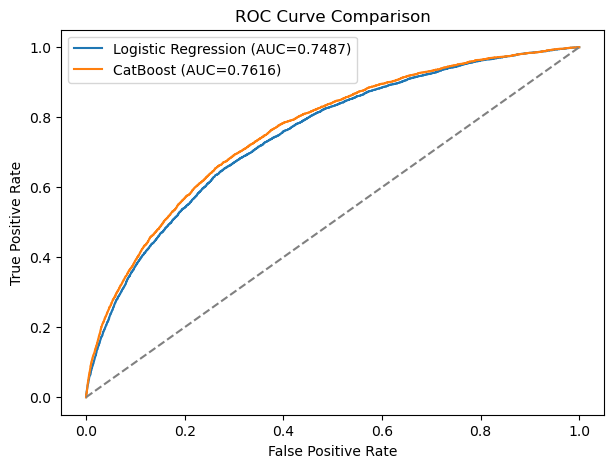

In [16]:
# 3. Plot ROC Curves
fpr_log, tpr_log, _ = roc_curve(y_test, log_probs)
fpr_cat, tpr_cat, _ = roc_curve(y_test, cat_probs)

plt.figure(figsize=(7,5))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={log_auc:.4f})")
plt.plot(fpr_cat, tpr_cat, label=f"CatBoost (AUC={cat_auc:.4f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

In [17]:
#Define business cost values for false positives and false negatives

In [18]:
# Define business costs
cost_fp = 500    # Cost of false positive
cost_fn = 2000   # Cost of false negative

In [19]:
probs = cat_probs   # predicted probabilities from CatBoost

thresholds = np.linspace(0, 1, 101)  # thresholds from 0 to 1
costs = []
conf_matrices = []

for t in thresholds:
    y_pred = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)
    conf_matrices.append((tn, fp, fn, tp))

In [20]:
# Find best threshold
best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
min_cost = costs[best_idx]
best_cm = conf_matrices[best_idx]

print("=== Business Cost Optimization ===")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Minimum Total Cost: {min_cost}")
print(f"Confusion Matrix (tn, fp, fn, tp): {best_cm}")

=== Business Cost Optimization ===
Best Threshold: 0.2100
Minimum Total Cost: 8726000
Confusion Matrix (tn, fp, fn, tp): (np.int64(53602), np.int64(2936), np.int64(3629), np.int64(1336))


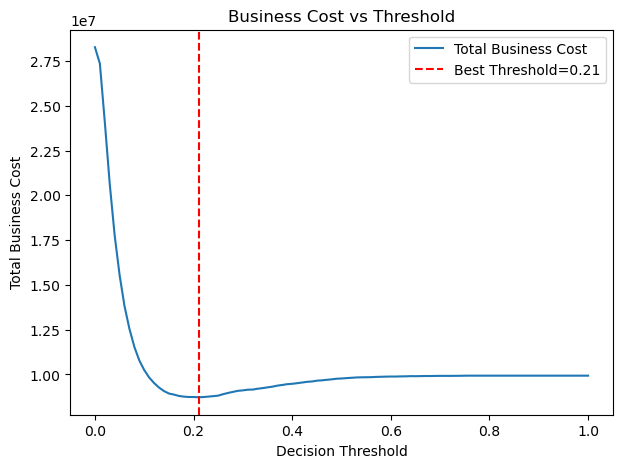

In [21]:
# Plot cost vs threshold
plt.figure(figsize=(7,5))
plt.plot(thresholds, costs, label="Total Business Cost")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold={best_threshold:.2f}")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost")
plt.title("Business Cost vs Threshold")
plt.legend()
plt.show()

In [22]:
# Adjust the model threshold to minimize total business cost 

In [23]:
# Use predicted probabilities from best model (e.g., CatBoost)
probs = cat_probs   # You can also use log_probs from Logistic Regression

# Define business costs
cost_fp = 500    # false positive (approve bad loan)
cost_fn = 2000   # false negative (reject good loan)

In [24]:
# Search thresholds between 0 and 1
thresholds = np.linspace(0, 1, 101)
costs = []
conf_matrices = []

for t in thresholds:
    y_pred = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    total_cost = fp * cost_fp + fn * cost_fn
    costs.append(total_cost)
    conf_matrices.append((tn, fp, fn, tp))

In [25]:
# Best threshold
best_idx = np.argmin(costs)
best_threshold = thresholds[best_idx]
min_cost = costs[best_idx]
best_cm = conf_matrices[best_idx]

print("=== Optimal Threshold Adjustment ===")
print(f"Best Threshold: {best_threshold:.4f}")
print(f"Minimum Total Cost: {min_cost}")
print(f"Confusion Matrix (tn, fp, fn, tp): {best_cm}")

# Evaluate with new threshold
y_pred_best = (probs >= best_threshold).astype(int)
print("\nClassification Report (Optimal Threshold):")
print(classification_report(y_test, y_pred_best, digits=4, zero_division=0))

=== Optimal Threshold Adjustment ===
Best Threshold: 0.2100
Minimum Total Cost: 8726000
Confusion Matrix (tn, fp, fn, tp): (np.int64(53602), np.int64(2936), np.int64(3629), np.int64(1336))

Classification Report (Optimal Threshold):
              precision    recall  f1-score   support

           0     0.9366    0.9481    0.9423     56538
           1     0.3127    0.2691    0.2893      4965

    accuracy                         0.8933     61503
   macro avg     0.6247    0.6086    0.6158     61503
weighted avg     0.8862    0.8933    0.8896     61503



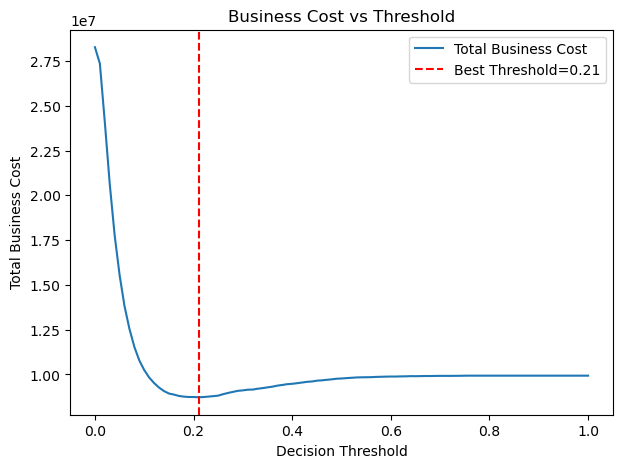

In [26]:
# Plot cost vs threshold
plt.figure(figsize=(7,5))
plt.plot(thresholds, costs, label="Total Business Cost")
plt.axvline(best_threshold, color="red", linestyle="--", label=f"Best Threshold={best_threshold:.2f}")
plt.xlabel("Decision Threshold")
plt.ylabel("Total Business Cost")
plt.title("Business Cost vs Threshold")
plt.legend()
plt.show()